In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- Import Libraries ---
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import os
from functools import reduce
import warnings
warnings.filterwarnings("ignore")

# --- Preprocessing with SMOTE ---
def preprocess_data_with_smote(df):
    df = df.copy()
    label_cols = ['PTSD', 'Bipolar disorder', 'Schizophrenia', 'Depression', 'Anxiety disorder']

    for col in df.columns:
        for target in label_cols:
            if col.strip().lower() == target.lower():
                df.rename(columns={col: target}, inplace=True)

    feature_cols = [col for col in df.columns if col not in label_cols + ['ID']]
    all_balanced_dfs = []

    print("=== Label Distribution Check (SMOTE) ===")
    for label in label_cols:
        subset = df[[label] + feature_cols].dropna(subset=[label])
        if subset[label].nunique() < 2:
            print(f"⚠️ Skipping {label}: Only one class present.")
            continue

        X = subset[feature_cols].values
        y = subset[label].values

        try:
            smote = SMOTE(random_state=42)
            X_res, y_res = smote.fit_resample(X, y)

            balanced_df = pd.DataFrame(X_res, columns=feature_cols)
            balanced_df[label] = y_res
            all_balanced_dfs.append(balanced_df)
            print(f"{label}: Resampled to {len(y_res)} samples.")
        except ValueError as e:
            print(f"⚠️ SMOTE failed for {label}: {e}")

    if not all_balanced_dfs:
        raise ValueError("❌ No disorders had at least one sample per class.")

    merged_df = reduce(lambda left, right: pd.merge(left, right, how='outer', on=feature_cols), all_balanced_dfs)

    for col in label_cols:
        if col not in merged_df.columns:
            merged_df[col] = 0
    merged_df[label_cols] = merged_df[label_cols].fillna(0).astype(int)

    return merged_df

# --- Model Factory ---
def get_model(model_name):
    if model_name == "Decision Tree":
        return DecisionTreeClassifier(random_state=42)
    elif model_name == "Random Forest":
        return RandomForestClassifier(n_estimators=100, random_state=42)
    elif model_name == "Gradient Boosting":
        return GradientBoostingClassifier(n_estimators=100, random_state=42)
    elif model_name == "KNN":
        return KNeighborsClassifier(n_neighbors=5)
    elif model_name == "SVM":
        return SVC(probability=True, random_state=42)
    elif model_name == "Extra Trees":
        return ExtraTreesClassifier(n_estimators=100, random_state=42)
    else:
        raise ValueError(f"Unknown model: {model_name}")

# --- Training and Evaluation ---
def train_and_evaluate_sklearn_models_kfold(df, folder_name, model_name):
    label_cols = ['PTSD', 'Bipolar disorder', 'Schizophrenia', 'Depression', 'Anxiety disorder']
    feature_cols = [col for col in df.columns if col not in label_cols]

    X = df[feature_cols].values
    y = df[label_cols].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    model_folder = os.path.join(folder_name, model_name.replace(" ", "_"))
    if not os.path.exists(model_folder):
        os.makedirs(model_folder)

    all_y_true = []
    all_y_pred_prob = []

    for fold, (train_index, test_index) in enumerate(kf.split(X_scaled), 1):
        print(f"\nTraining Fold {fold}/5 for {model_name}...")

        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = get_model(model_name)

        # Train one-vs-rest for multilabel
        y_pred_prob_fold = np.zeros(y_test.shape)
        for i in range(len(label_cols)):
            model.fit(X_train, y_train[:, i])
            if hasattr(model, "predict_proba"):
                y_pred_prob_fold[:, i] = model.predict_proba(X_test)[:, 1]
            else:
                y_pred_prob_fold[:, i] = model.predict(X_test)

        report = classification_report(y_test, y_pred_prob_fold > 0.5, target_names=label_cols, zero_division=0, output_dict=True, digits=4)
        auc_scores = {label_cols[i]: roc_auc_score(y_test[:, i], y_pred_prob_fold[:, i]) for i in range(len(label_cols))}

        result_df = pd.DataFrame(report).transpose()
        result_df['AUC'] = pd.Series(auc_scores)

        result_df.to_csv(os.path.join(model_folder, f'results_fold{fold}.csv'))
        print(result_df[['precision', 'recall', 'f1-score', 'AUC']])

        all_y_true.append(y_test)
        all_y_pred_prob.append(y_pred_prob_fold)

    # === Final overall report ===
    y_true_all = np.vstack(all_y_true)
    y_pred_all = np.vstack(all_y_pred_prob)

    final_report = classification_report(y_true_all, y_pred_all > 0.5, target_names=label_cols, zero_division=0, digits=4)
    final_auc = {label_cols[i]: roc_auc_score(y_true_all[:, i], y_pred_all[:, i]) for i in range(len(label_cols))}

    print(f"\n====== Overall Classification Report for {model_name} ======")
    print(final_report)

    print(f"\n====== Overall AUC Scores for {model_name} ======")
    for label, auc in final_auc.items():
        print(f"{label}: {auc:.4f}")

    # Save final AUCs
    final_df = pd.DataFrame(final_auc.items(), columns=['Disorder', 'AUC'])
    final_df.to_csv(os.path.join(model_folder, 'final_auc_scores.csv'), index=False)

# --- RUN PIPELINE ---

# Load Data
df = pd.read_csv('/content/drive/MyDrive/Mentalillness.csv')

# Preprocess
processed_df = preprocess_data_with_smote(df)

# Models to Train
models = ["Decision Tree", "Random Forest", "Gradient Boosting", "KNN", "SVM", "Extra Trees"]

for model_name in models:
    train_and_evaluate_sklearn_models_kfold(processed_df, 'MentalHealthResults_SMOTE', model_name)


=== Label Distribution Check (SMOTE) ===
PTSD: Resampled to 7100 samples.
Bipolar disorder: Resampled to 5818 samples.
Schizophrenia: Resampled to 6334 samples.
Depression: Resampled to 3816 samples.
Anxiety disorder: Resampled to 4262 samples.

Training Fold 1/5 for Decision Tree...
                  precision    recall  f1-score       AUC
PTSD               0.974175  0.979798  0.976978  0.984803
Bipolar disorder   0.843683  0.684028  0.755513  0.822630
Schizophrenia      0.809259  0.700321  0.750859  0.822095
Depression         0.702065  0.652055  0.676136  0.801911
Anxiety disorder   0.846715  0.754881  0.798165  0.861675
micro avg          0.854116  0.770872  0.810361       NaN
macro avg          0.835180  0.754216  0.791530       NaN
weighted avg       0.850545  0.770872  0.807467       NaN
samples avg        0.536722  0.500366  0.506412       NaN

Training Fold 2/5 for Decision Tree...
                  precision    recall  f1-score       AUC
PTSD               0.966963  0.989597

In [ ]:
# --- Import Libraries ---
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import os
from functools import reduce
import warnings
warnings.filterwarnings("ignore")

# --- Preprocessing with SMOTE ---
def preprocess_data_with_smote(df):
    df = df.copy()
    label_cols = ['PTSD', 'Bipolar disorder', 'Schizophrenia', 'Depression', 'Anxiety disorder']

    for col in df.columns:
        for target in label_cols:
            if col.strip().lower() == target.lower():
                df.rename(columns={col: target}, inplace=True)

    feature_cols = [col for col in df.columns if col not in label_cols + ['ID']]
    all_balanced_dfs = []

    print("=== Label Distribution Check (SMOTE) ===")
    for label in label_cols:
        subset = df[[label] + feature_cols].dropna(subset=[label])
        if subset[label].nunique() < 2:
            print(f"⚠️ Skipping {label}: Only one class present.")
            continue

        X = subset[feature_cols].values
        y = subset[label].values

        try:
            smote = SMOTE(random_state=42)
            X_res, y_res = smote.fit_resample(X, y)

            balanced_df = pd.DataFrame(X_res, columns=feature_cols)
            balanced_df[label] = y_res
            all_balanced_dfs.append(balanced_df)
            print(f"{label}: Resampled to {len(y_res)} samples.")
        except ValueError as e:
            print(f"⚠️ SMOTE failed for {label}: {e}")

    if not all_balanced_dfs:
        raise ValueError("❌ No disorders had at least one sample per class.")

    merged_df = reduce(lambda left, right: pd.merge(left, right, how='outer', on=feature_cols), all_balanced_dfs)

    for col in label_cols:
        if col not in merged_df.columns:
            merged_df[col] = 0
    merged_df[label_cols] = merged_df[label_cols].fillna(0).astype(int)

    return merged_df

# --- Training and Evaluation for TabNet ---
def train_and_evaluate_tabnet_kfold(df, folder_name):
    label_cols = ['PTSD', 'Bipolar disorder', 'Schizophrenia', 'Depression', 'Anxiety disorder']
    feature_cols = [col for col in df.columns if col not in label_cols]

    X = df[feature_cols].values
    y = df[label_cols].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    model_folder = os.path.join(folder_name, 'TabNet')
    if not os.path.exists(model_folder):
        os.makedirs(model_folder)

    all_y_true = []
    all_y_pred_prob = []

    for fold, (train_index, test_index) in enumerate(kf.split(X_scaled), 1):
        print(f"\nTraining Fold {fold}/5 for TabNet...")

        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_pred_prob_fold = np.zeros(y_test.shape)

        for i in range(len(label_cols)):
            clf = TabNetClassifier(
                verbose=0,
                seed=42,
                device_name='cuda' if torch.cuda.is_available() else 'cpu'
            )

            clf.fit(
                X_train, y_train[:, i],
                eval_set=[(X_test, y_test[:, i])],
                patience=10,
                batch_size=512,
                virtual_batch_size=128
            )

            y_pred_prob_fold[:, i] = clf.predict_proba(X_test)[:, 1]

        report = classification_report(y_test, y_pred_prob_fold > 0.5, target_names=label_cols, zero_division=0, output_dict=True, digits=4)
        auc_scores = {label_cols[i]: roc_auc_score(y_test[:, i], y_pred_prob_fold[:, i]) for i in range(len(label_cols))}

        result_df = pd.DataFrame(report).transpose()
        result_df['AUC'] = pd.Series(auc_scores)

        result_df.to_csv(os.path.join(model_folder, f'results_fold{fold}.csv'))
        print(result_df[['precision', 'recall', 'f1-score', 'AUC']])

        all_y_true.append(y_test)
        all_y_pred_prob.append(y_pred_prob_fold)

    # === Final overall report ===
    y_true_all = np.vstack(all_y_true)
    y_pred_all = np.vstack(all_y_pred_prob)

    final_report = classification_report(y_true_all, y_pred_all > 0.5, target_names=label_cols, zero_division=0, digits=4)
    final_auc = {label_cols[i]: roc_auc_score(y_true_all[:, i], y_pred_all[:, i]) for i in range(len(label_cols))}

    print(f"\n====== Overall Classification Report for TabNet ======")
    print(final_report)

    print(f"\n====== Overall AUC Scores for TabNet ======")
    for label, auc in final_auc.items():
        print(f"{label}: {auc:.4f}")

    # Save final AUCs
    final_df = pd.DataFrame(final_auc.items(), columns=['Disorder', 'AUC'])
    final_df.to_csv(os.path.join(model_folder, 'final_auc_scores.csv'), index=False)

# --- RUN PIPELINE ---

# Load Data
df = pd.read_csv('/content/drive/MyDrive/Mentalillness.csv')

# Preprocess
processed_df = preprocess_data_with_smote(df)

# Train TabNet
train_and_evaluate_tabnet_kfold(processed_df, 'MentalHealthResults_SMOTE')


=== Label Distribution Check (SMOTE) ===
PTSD: Resampled to 7100 samples.
Bipolar disorder: Resampled to 5818 samples.
Schizophrenia: Resampled to 6334 samples.
Depression: Resampled to 3816 samples.
Anxiety disorder: Resampled to 4262 samples.

Training Fold 1/5 for TabNet...

Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_auc = 0.99802

Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_0_auc = 0.9886

Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_0_auc = 0.98327

Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_auc = 0.99126

Early stopping occurred at epoch 50 with best_epoch = 40 and best_val_0_auc = 0.98148
                  precision    recall  f1-score       AUC
PTSD               0.971671  0.989899  0.980701  0.998024
Bipolar disorder   0.946691  0.894097  0.919643  0.988600
Schizophrenia      0.911184  0.887821  0.899351  0.983272
Depression         0.922865  0.917808  0.920330  0.99125

=== Label Distribution Check (SMOTE) ===
PTSD: Resampled to 7100 samples.
Bipolar disorder: Resampled to 5818 samples.
Schizophrenia: Resampled to 6334 samples.
Depression: Resampled to 3816 samples.
Anxiety disorder: Resampled to 4262 samples.

Training Fold 1/5...
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
                  precision    recall  f1-score       AUC
PTSD               0.973404  0.985195  0.979264  0.997462
Bipolar disorder   0.923792  0.925512  0.924651  0.992801
Schizophrenia      0.913399  0.919408  0.916393  0.988919
Depression         0.884817  0.918478  0.901333  0.988888
Anxiety disorder   0.879607  0.858513  0.868932  0.986097
micro avg          0.923077  0.929293  0.926174       NaN
macro avg          0.915004  0.921421  0.918115       NaN
weighted avg       0.922959  0.929293  0.926051       NaN
samples avg        0.568479  0.572258  0.565308       NaN

Training Fold 2/5...
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
                  precision    recall  f1-score      

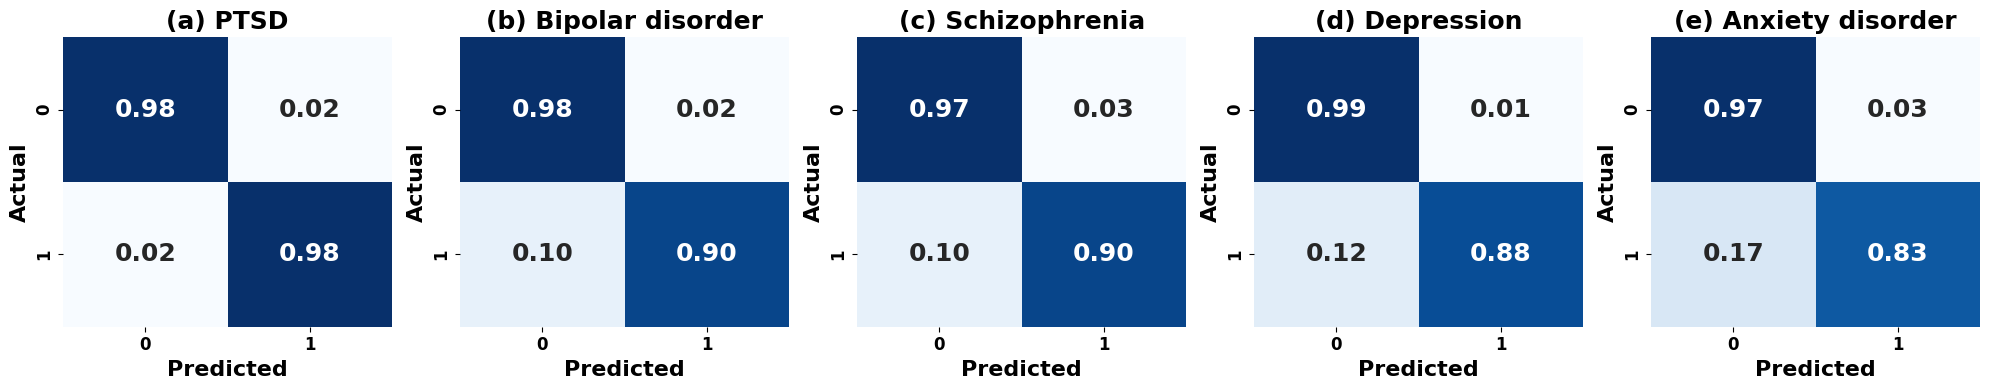

In [ ]:
# --- Import Libraries ---
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
import os
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# --- Preprocessing with SMOTE ---
def preprocess_data_with_smote(df):
    df = df.copy()
    label_cols = ['PTSD', 'Bipolar disorder', 'Schizophrenia', 'Depression', 'Anxiety disorder']

    for col in df.columns:
        for target in label_cols:
            if col.strip().lower() == target.lower():
                df.rename(columns={col: target}, inplace=True)

    feature_cols = [col for col in df.columns if col not in label_cols + ['ID']]
    all_balanced_dfs = []

    print("=== Label Distribution Check (SMOTE) ===")
    for label in label_cols:
        subset = df[[label] + feature_cols].dropna(subset=[label])
        if subset[label].nunique() < 2:
            print(f"⚠️ Skipping {label}: Only one class present.")
            continue

        X = subset[feature_cols].values
        y = subset[label].values

        try:
            smote = SMOTE(random_state=42)
            X_res, y_res = smote.fit_resample(X, y)

            balanced_df = pd.DataFrame(X_res, columns=feature_cols)
            balanced_df[label] = y_res
            all_balanced_dfs.append(balanced_df)
            print(f"{label}: Resampled to {len(y_res)} samples.")
        except ValueError as e:
            print(f"⚠️ SMOTE failed for {label}: {e}")

    if not all_balanced_dfs:
        raise ValueError("❌ No disorders had at least one sample per class.")

    merged_df = reduce(lambda left, right: pd.merge(left, right, how='outer', on=feature_cols), all_balanced_dfs)

    for col in label_cols:
        if col not in merged_df.columns:
            merged_df[col] = 0
    merged_df[label_cols] = merged_df[label_cols].fillna(0).astype(int)

    return merged_df

# --- Model Architecture ---
def create_model(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(output_dim, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])
    return model

def plot_confusion_matrices(y_true_all, y_pred_all, label_cols, save_path=None):
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    fig.subplots_adjust(wspace=0.4)

    plt.rcParams.update({'font.weight': 'bold', 'axes.labelweight': 'bold'})

    for idx, label in enumerate(label_cols):
        ax = axes[idx]
        y_true = y_true_all[:, idx]
        y_pred = (y_pred_all[:, idx] > 0.5).astype(int)

        cm = confusion_matrix(y_true, y_pred)
        cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        cm_normalized = np.nan_to_num(cm_normalized)  # Handle division by zero

        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=False,
                    annot_kws={'size': 18, 'weight': 'bold'}, ax=ax)

        ax.set_title(f'({chr(97+idx)}) {label}', fontsize=18, fontweight='bold')
        ax.set_xlabel('Predicted', fontsize=16, fontweight='bold')
        ax.set_ylabel('Actual', fontsize=16, fontweight='bold')

        ax.tick_params(axis='both', labelsize=14)
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, fontweight='bold')
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, fontweight='bold')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='tiff', dpi=1200)
    plt.show()

# --- K-Fold Training and Evaluation ---
def train_and_evaluate_keras_model_kfold_with_metrics_and_auc(df, folder_name):
    label_cols = ['PTSD', 'Bipolar disorder', 'Schizophrenia', 'Depression', 'Anxiety disorder']
    feature_cols = [col for col in df.columns if col not in label_cols]

    X = df[feature_cols].values
    y = df[label_cols].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    all_y_true = []
    all_y_pred_prob = []

    for fold, (train_index, test_index) in enumerate(kf.split(X_scaled), 1):
        print(f"\nTraining Fold {fold}/5...")

        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = create_model(input_dim=X_train.shape[1], output_dim=y_train.shape[1])
        model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), verbose=0)

        y_pred_prob = model.predict(X_test)

        report = classification_report(y_test, y_pred_prob > 0.5, target_names=label_cols, zero_division=0, output_dict=True)
        auc_scores = {label_cols[i]: roc_auc_score(y_test[:, i], y_pred_prob[:, i]) for i in range(len(label_cols))}

        result_df = pd.DataFrame(report).transpose()
        result_df['AUC'] = pd.Series(auc_scores)

        result_df.to_csv(os.path.join(folder_name, f'results_fold{fold}.csv'))
        print(result_df[['precision', 'recall', 'f1-score', 'AUC']])

        all_y_true.append(y_test)
        all_y_pred_prob.append(y_pred_prob)

    # === Final overall report ===
    y_true_all = np.vstack(all_y_true)
    y_pred_all = np.vstack(all_y_pred_prob)

    final_report = classification_report(y_true_all, y_pred_all > 0.5, target_names=label_cols, zero_division=0)
    final_auc = {label_cols[i]: roc_auc_score(y_true_all[:, i], y_pred_all[:, i]) for i in range(len(label_cols))}

    print("\n====== Overall Classification Report ======")
    print(final_report)

    print("\n====== Overall AUC Scores ======")
    for label, auc in final_auc.items():
        print(f"{label}: {auc:.4f}")

    # Save final AUCs
    final_df = pd.DataFrame(final_auc.items(), columns=['Disorder', 'AUC'])
    final_df.to_csv(os.path.join(folder_name, 'final_auc_scores.csv'), index=False)

    # Plot and save confusion matrices
    plot_confusion_matrices(y_true_all, y_pred_all, label_cols,
        save_path='/content/drive/MyDrive/confusion_matrices.tiff')

# --- RUN PIPELINE ---

# Load Data
df = pd.read_csv('/content/drive/MyDrive/Mentalillness.csv')

# Preprocess
processed_df = preprocess_data_with_smote(df)

# Train and Evaluate
train_and_evaluate_keras_model_kfold_with_metrics_and_auc(processed_df, 'MentalHealthResults_SMOTE')


In [ ]:
def show_resampled_distribution(df, label_cols):
    print("\n=== Distribution After Resampling with SMOTE ===")
    for label in label_cols:
        if label in df.columns:
            count_1 = df[df[label] == 1].shape[0]
            count_0 = df[df[label] == 0].shape[0]
            print(f"{label}: Positives = {count_1}, Negatives = {count_0}")
label_cols = ['PTSD', 'Bipolar disorder', 'Schizophrenia', 'Depression', 'Anxiety disorder']
show_resampled_distribution(processed_df, label_cols)



=== Distribution After Resampling with SMOTE ===
PTSD: Positives = 3614, Negatives = 8666
Bipolar disorder: Positives = 2909, Negatives = 9371
Schizophrenia: Positives = 3167, Negatives = 9113
Depression: Positives = 1921, Negatives = 10359
Anxiety disorder: Positives = 2217, Negatives = 10063


In [ ]:
!pip install shap

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f21ff045749f003abed210da8c409d3625221145e5bbdc88b897992825081883
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime



Training Fold 1/5...
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Training Fold 2/5...
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Training Fold 3/5...
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Training Fold 4/5...
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Training Fold 5/5...
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


PermutationExplainer explainer: 751it [00:27, 18.55it/s]                         



SHAP summary plot saved at '/content/drive/MyDrive/SHAP_Summary_Schizophrenia_Full.tiff'


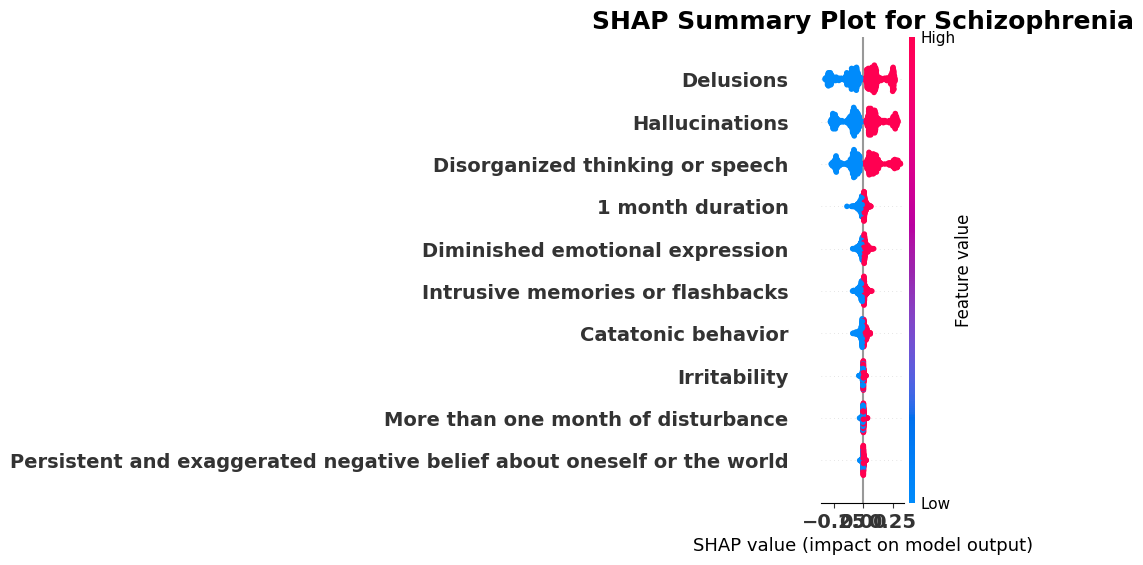

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
LIME explanation saved at '/content/drive/MyDrive/LIME_Explanation_Schizophrenia.html'



Metrics Summary for Schizophrenia:
Accuracy: 0.9797
Precision: 0.9802
Recall: 0.9962
F1 Score: 0.9881
AUC: 0.9972


In [ ]:
import numpy as np
import pandas as pd
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense

# Train and evaluate function for Schizophrenia
def train_and_evaluate_schizophrenia(df, n_splits=5):
    X = df.drop(['Bipolar disorder', 'Schizophrenia', 'Depression', 'Anxiety disorder', 'PTSD', "ID"], axis=1)
    y = df['Schizophrenia']

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics_summary = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}

    for fold_idx, (train_idx, test_idx) in enumerate(kfold.split(X)):
        print(f"\nTraining Fold {fold_idx + 1}/{n_splits}...")

        # Split data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Define and compile the Keras model
        input_dim = X.shape[1]
        input_layer = Input(shape=(input_dim,))
        shared = Dense(128, activation='relu')(input_layer)
        shared = Dense(64, activation='relu')(shared)
        output = Dense(1, activation='sigmoid', name='schizophrenia')(shared)
        model = Model(inputs=input_layer, outputs=output)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train the model
        model.fit(
            X_train_scaled, y_train,
            validation_data=(X_test_scaled, y_test),
            epochs=5,
            batch_size=64,
            verbose=0
        )

        # Make predictions and calculate metrics
        y_pred_proba = model.predict(X_test_scaled).flatten()
        y_pred_binary = (y_pred_proba > 0.5).astype(int)

        acc = accuracy_score(y_test, y_pred_binary)
        prec = precision_score(y_test, y_pred_binary, zero_division=0)
        rec = recall_score(y_test, y_pred_binary, zero_division=0)
        f1 = f1_score(y_test, y_pred_binary, zero_division=0)
        auc = roc_auc_score(y_test, y_pred_proba)

        # Store metrics for each fold
        metrics_summary['accuracy'].append(acc)
        metrics_summary['precision'].append(prec)
        metrics_summary['recall'].append(rec)
        metrics_summary['f1'].append(f1)
        metrics_summary['auc'].append(auc)

    # SHAP Interpretation
    explainer = shap.Explainer(model, X_train_scaled)
    shap_values = explainer(X_test_scaled)

    # SHAP Summary Plot
    plt.figure(figsize=(15, 10))
    shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, show=False, max_display=10)
    plt.title("SHAP Summary Plot for Schizophrenia", fontsize=18, fontweight='bold')
    plt.xticks(fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold')

    output_path = '/content/drive/MyDrive/SHAP_Summary_Schizophrenia_Full.tiff'
    plt.savefig(output_path, format='tiff', dpi=2400, bbox_inches='tight')
    print(f"\nSHAP summary plot saved at '{output_path}'")
    plt.show()
    plt.close()

    # LIME Interpretation
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train_scaled, mode="classification",
        feature_names=X.columns.tolist(),
        class_names=["Not Schizophrenia", "Schizophrenia"],
        discretize_continuous=True
    )

    # Fix: LIME requires a function that returns 2D probability array
    def predict_proba(X):
        proba = model.predict(X)
        return np.hstack([1 - proba, proba])  # Convert to (n_samples, 2) shape

    idx = np.random.randint(0, X_test_scaled.shape[0])  # Pick a random test sample
    exp = lime_explainer.explain_instance(X_test_scaled[idx], predict_proba, num_features=10)

    output_lime_path = '/content/drive/MyDrive/LIME_Explanation_Schizophrenia.html'
    exp.save_to_file(output_lime_path)
    print(f"LIME explanation saved at '{output_lime_path}'")

    exp.show_in_notebook()

    # Print aggregated metrics
    print("\nMetrics Summary for Schizophrenia:")
    print(f"Accuracy: {np.mean(metrics_summary['accuracy']):.4f}")
    print(f"Precision: {np.mean(metrics_summary['precision']):.4f}")
    print(f"Recall: {np.mean(metrics_summary['recall']):.4f}")
    print(f"F1 Score: {np.mean(metrics_summary['f1']):.4f}")
    print(f"AUC: {np.mean(metrics_summary['auc']):.4f}")

# Load dataset and run the function
df = pd.read_csv('/content/drive/MyDrive/Mentalillness.csv')
train_and_evaluate_schizophrenia(df)
